In [47]:
import xgboost
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, confusion_matrix_at_thresholds
)
import matplotlib.pyplot as plt

import shap
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler

In [18]:
# dataset = pd.read_parquet('./preprocessed_datasets/dataset_alpha_0.4_full_binarytarget_win-24_thresh-19_both_dynamic-True.parquet')
# dataset = pd.read_parquet('./preprocessed_datasets/dataset_alpha_0.4_full_binarytarget_win-24_thresh-15_both_dynamic-False.parquet')
dataset = pd.read_parquet('./preprocessed_datasets/dataset_alpha_1.0_full_binarytarget_win-24_thresh-15_both_dynamic-False.parquet')
dataset['timestamp'] = dataset.index

In [19]:
for k in range(1, 8):
    dataset[f"poolTick_lag{k}h"] = dataset["poolTick"].shift(k)


In [ ]:
TIME_COL = "timestamp"   
TARGET_COL = "target"    
df = dataset.copy()


df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df = df.sort_values(TIME_COL).reset_index(drop=True)


FEATURES = [c for c in df.columns if c not in [TIME_COL, TARGET_COL]]

X = df[FEATURES]
y = df[TARGET_COL].astype(int)

n = len(df)
test_size = int(0.30 * n)
val_size  = int(0.15 * n)

train_end = n - test_size
val_end = train_end
train_end2 = train_end - val_size

X_train, y_train = X.iloc[:train_end2], y.iloc[:train_end2]
X_val,   y_val   = X.iloc[train_end2:val_end], y.iloc[train_end2:val_end]
X_test,  y_test  = X.iloc[val_end:], y.iloc[val_end:]

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_val_scaled   = X_val.copy()
X_test_scaled  = X_test.copy()

num_cols = X_train.columns  # assuming all features are numeric
# If only some numeric:
# num_cols = X_train.select_dtypes(include=np.number).columns

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val_scaled[num_cols]   = scaler.transform(X_val[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test[num_cols])

X_train, X_val, X_test = X_train_scaled, X_val_scaled, X_test_scaled
# n_pos = (y_train == 1).sum()
# n_neg = (y_train == 0).sum()
# w_pos = (n_neg / max(n_pos, 1))

# w_train = np.where(y_train.values == 1, w_pos, 1.0)
# w_val   = np.where(y_val.values   == 1, w_pos, 1.0)
# w_test  = np.where(y_test.values  == 1, w_pos, 1.0)  # only used if you want weighted metrics

# print(f"Train positives={n_pos}, negatives={n_neg}, w_pos={w_pos:.3f}")



In [21]:
bal = (len(y)-sum(y))/sum(y)

model = XGBClassifier(
    n_estimators=800,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=1.0,
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=bal,      
    random_state=1233,
)

model.fit(
    X_train, y_train,    
    eval_set=[(X_train, y_train),(X_val, y_val)],
    early_stopping_rounds=200
)

print("Best iteration:", model.best_iteration)

[0]	validation_0-auc:0.97527	validation_1-auc:0.39422


/home/jovyan/.conda/envs/GPU/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-auc:0.99179	validation_1-auc:0.48661
[2]	validation_0-auc:0.99252	validation_1-auc:0.36784
[3]	validation_0-auc:0.99244	validation_1-auc:0.44562
[4]	validation_0-auc:0.99256	validation_1-auc:0.41803
[5]	validation_0-auc:0.99232	validation_1-auc:0.41404
[6]	validation_0-auc:0.99384	validation_1-auc:0.41441
[7]	validation_0-auc:0.99512	validation_1-auc:0.43765
[8]	validation_0-auc:0.99451	validation_1-auc:0.43761
[9]	validation_0-auc:0.99479	validation_1-auc:0.43244
[10]	validation_0-auc:0.99469	validation_1-auc:0.42752
[11]	validation_0-auc:0.99436	validation_1-auc:0.42469
[12]	validation_0-auc:0.99455	validation_1-auc:0.43049
[13]	validation_0-auc:0.99454	validation_1-auc:0.42713
[14]	validation_0-auc:0.99473	validation_1-auc:0.43087
[15]	validation_0-auc:0.99489	validation_1-auc:0.43153
[16]	validation_0-auc:0.99494	validation_1-auc:0.43108
[17]	validation_0-auc:0.99490	validation_1-auc:0.41990
[18]	validation_0-auc:0.99558	validation_1-auc:0.83732
[19]	validation_0-a


=== Test Metrics ===
ROC AUC : 0.7942
AUPRC   : 0.1980

Confusion matrix (threshold = 0.50):
[[10233     0]
 [  568     0]]

Classification report:
               precision    recall  f1-score   support

           0     0.9474    1.0000    0.9730     10233
           1     0.0000    0.0000    0.0000       568

    accuracy                         0.9474     10801
   macro avg     0.4737    0.5000    0.4865     10801
weighted avg     0.8976    0.9474    0.9218     10801

Best threshold by Youden's J: 0.006 (TPR=0.776, FPR=0.342)


/home/jovyan/.conda/envs/GPU/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/jovyan/.conda/envs/GPU/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/jovyan/.conda/envs/GPU/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

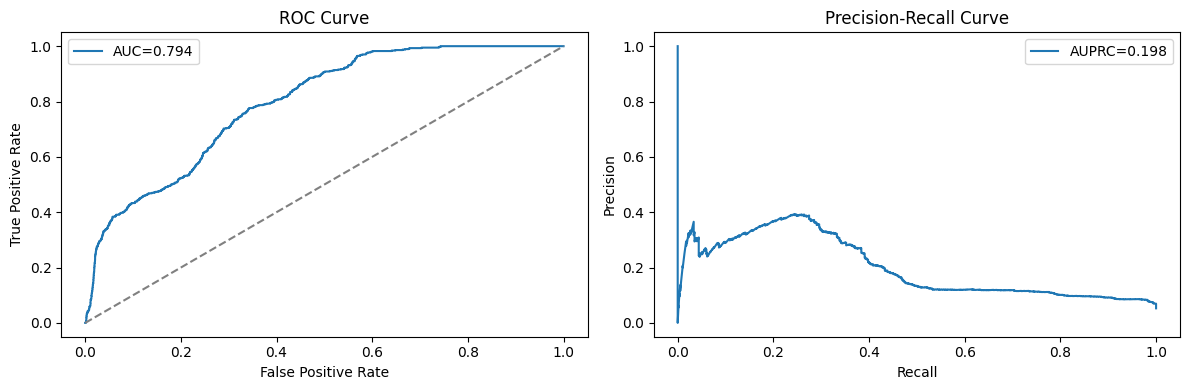

In [22]:
proba_test = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, proba_test)
auprc = average_precision_score(y_test, proba_test)

print("\n=== Test Metrics ===")
print(f"ROC AUC : {auc:.4f}")
print(f"AUPRC   : {auprc:.4f}")

# Pick a threshold (0.5 default). Often for imbalance you may tune it.
threshold = 0.50
yhat_test = (proba_test >= threshold).astype(int)

cm = confusion_matrix(y_test, yhat_test)
print("\nConfusion matrix (threshold = %.2f):\n%s" % (threshold, cm))
print("\nClassification report:\n", classification_report(y_test, yhat_test, digits=4))

# Plot ROC + PR curves
fpr, tpr, thresholds = roc_curve(y_test, proba_test)
prec, rec, _ = precision_recall_curve(y_test, proba_test)
j = tpr - fpr
best_idx = np.argmax(j)
thresh = thresholds[best_idx]
print(f"Best threshold by Youden's J: {thresh:.3f} (TPR={tpr[best_idx]:.3f}, FPR={fpr[best_idx]:.3f})")
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(fpr, tpr, label=f"AUC={auc:.3f}")
ax[0].plot([0, 1], [0, 1], "--", color="gray")
ax[0].set_title("ROC Curve")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].legend()

ax[1].plot(rec, prec, label=f"AUPRC={auprc:.3f}")
ax[1].set_title("Precision-Recall Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].legend()

plt.tight_layout()
plt.show()

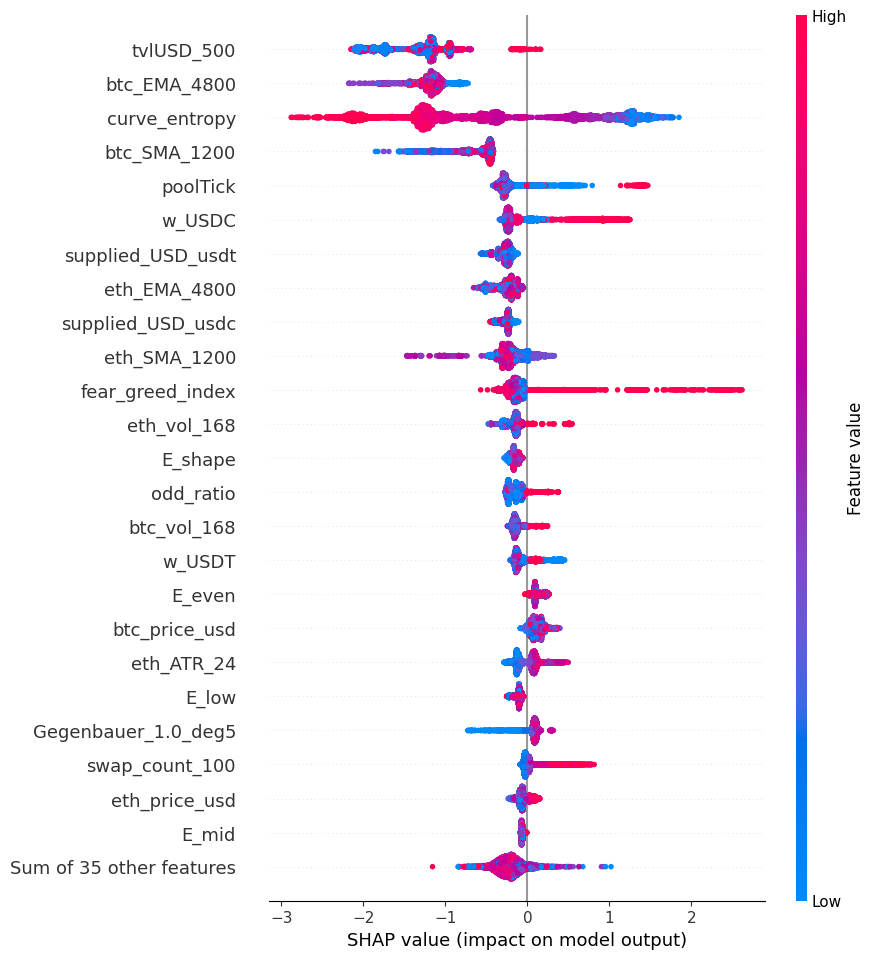

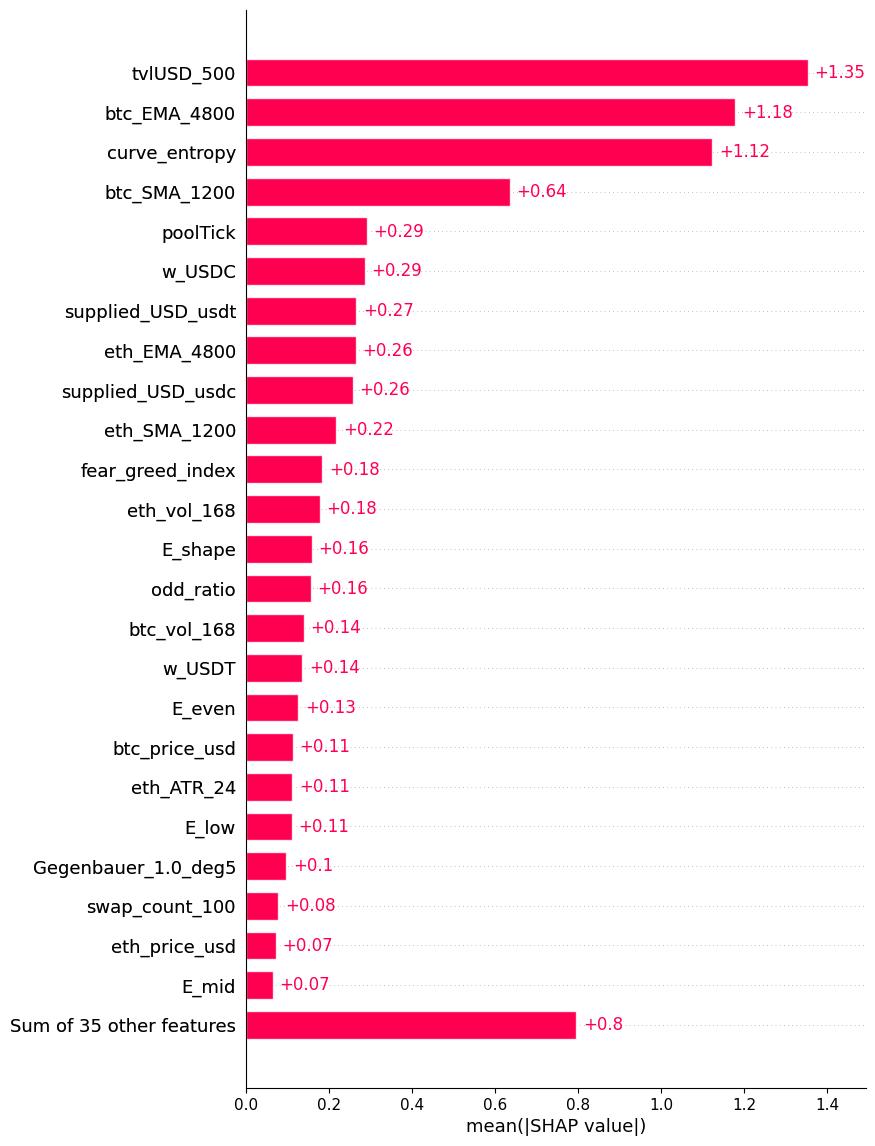

In [ ]:
X_explain = X_test.copy()
# if len(X_explain) > 5000:
#     X_explain = X_explain.sample(5000, random_state=42)

explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
shap_values = explainer(X_explain)  # shap.Explanation

# Global importance (beeswarm)
shap.plots.beeswarm(shap_values, max_display=25)
shap.plots.bar(shap_values, max_display=25)

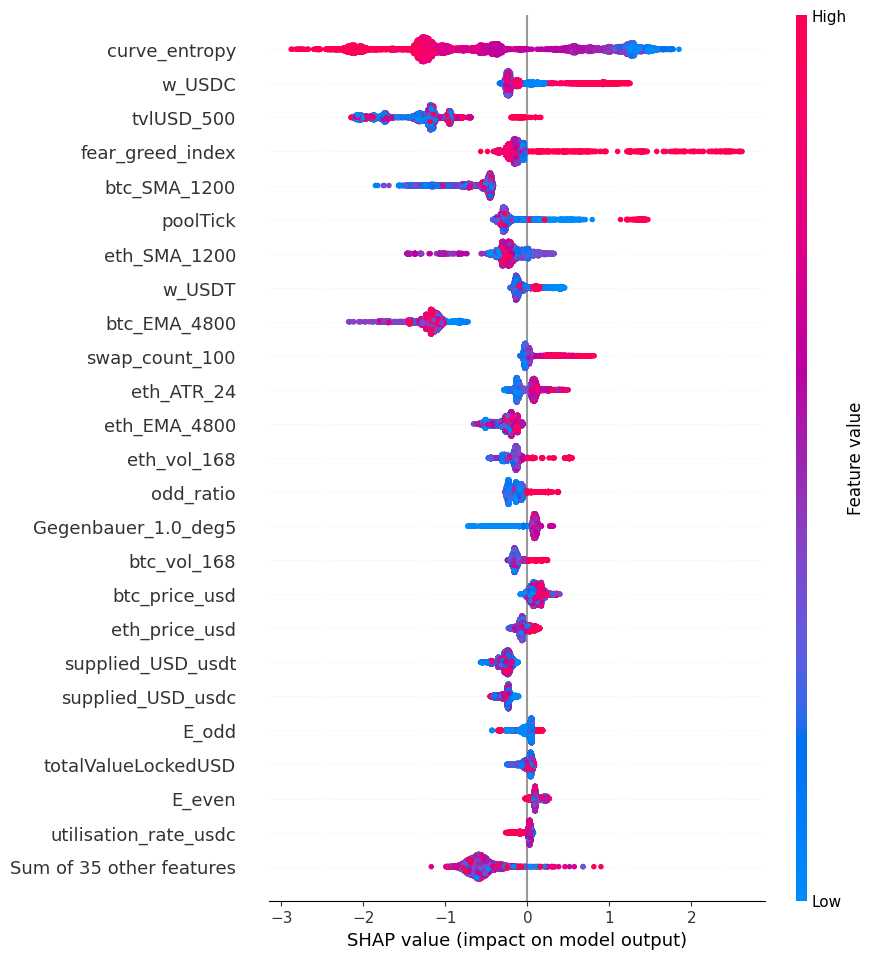

In [122]:
std_per_feature = shap_values.values.std(axis=0)          
order = np.argsort(std_per_feature)[::-1]   
shap.plots.beeswarm(shap_values, order=order, max_display=25)

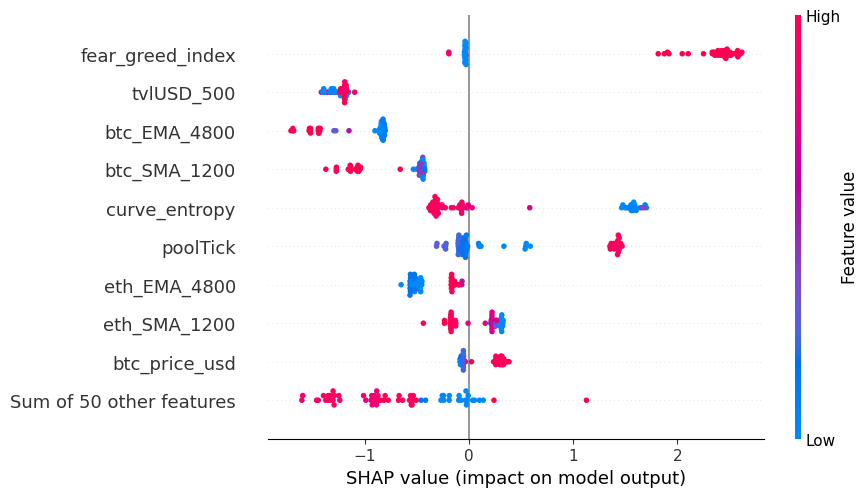

In [138]:
warn_mask = proba_test >= 0.2

sv_warn = shap_values[warn_mask]   

shap.plots.beeswarm(sv_warn)

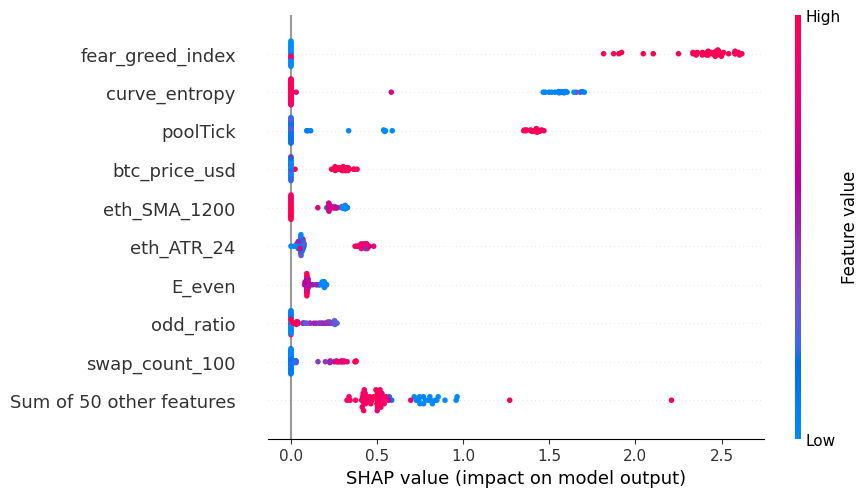

In [139]:
pos_mean = np.clip(sv_warn.values, 0, None).mean(axis=0)
order = np.argsort(pos_mean)[::-1]

shap.plots.beeswarm(sv_warn_pos, order=order)

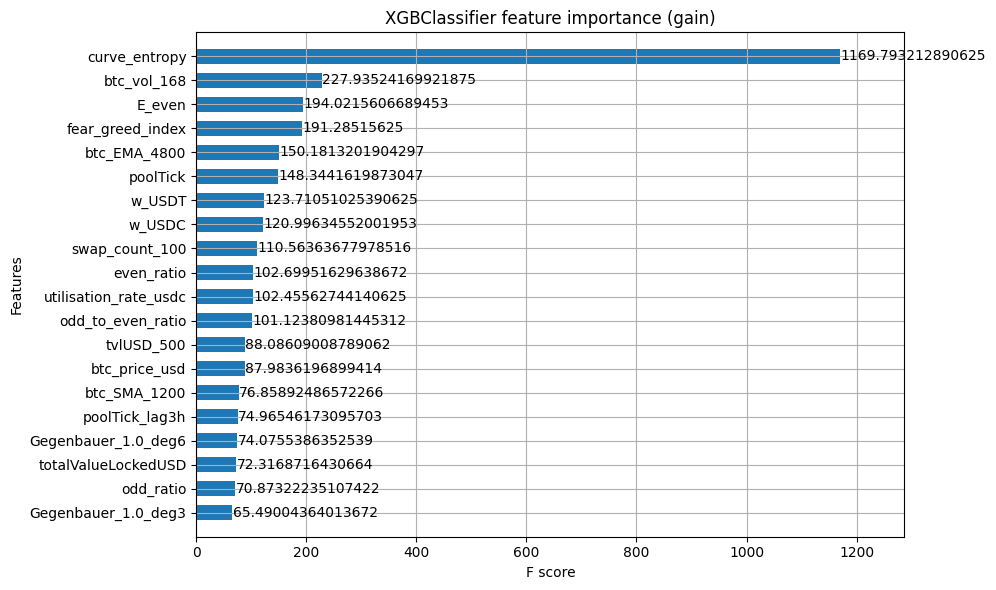

In [24]:
fig, ax = plt.subplots(figsize=(10,6))
plot_importance(
    model,
    importance_type="gain",   # "gain", "weight", "cover", "total_gain", "total_cover"
    max_num_features=20,
    height=.6,ax= ax
)
plt.title("XGBClassifier feature importance (gain)")
plt.tight_layout()
plt.show()

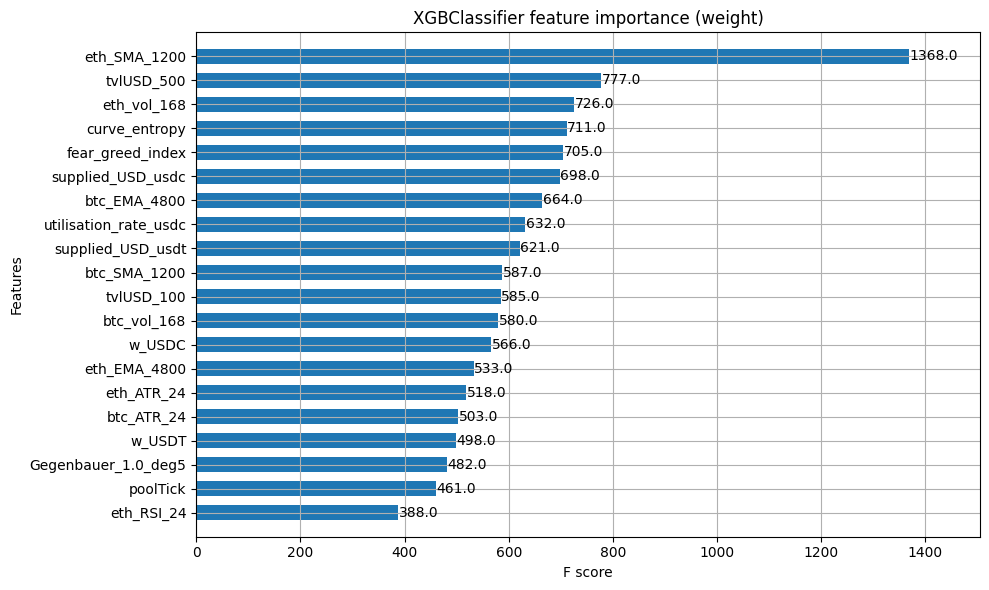

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
plot_importance(
    model,
    importance_type="weight",   # "gain", "weight", "cover", "total_gain", "total_cover"
    max_num_features=20,
    height=.6,ax= ax
)
plt.title("XGBClassifier feature importance (weight)")
plt.tight_layout()
plt.show()

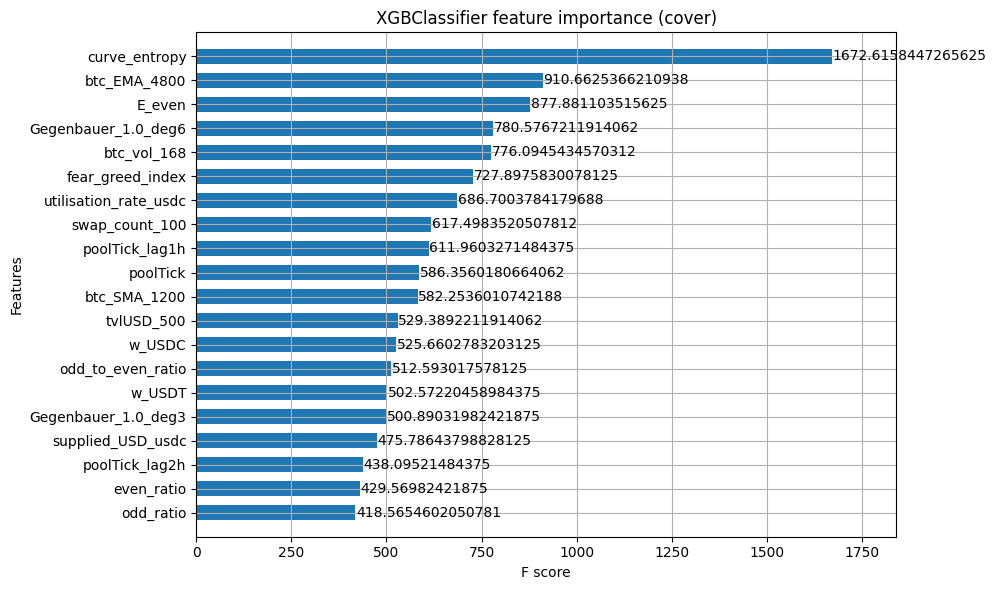

In [26]:
fig, ax = plt.subplots(figsize=(10,6))
plot_importance(
    model,
    importance_type="cover",   # "gain", "weight", "cover", "total_gain", "total_cover"
    max_num_features=20,
    height=.6,ax= ax
)
plt.title("XGBClassifier feature importance (cover)")
plt.tight_layout()
plt.show()

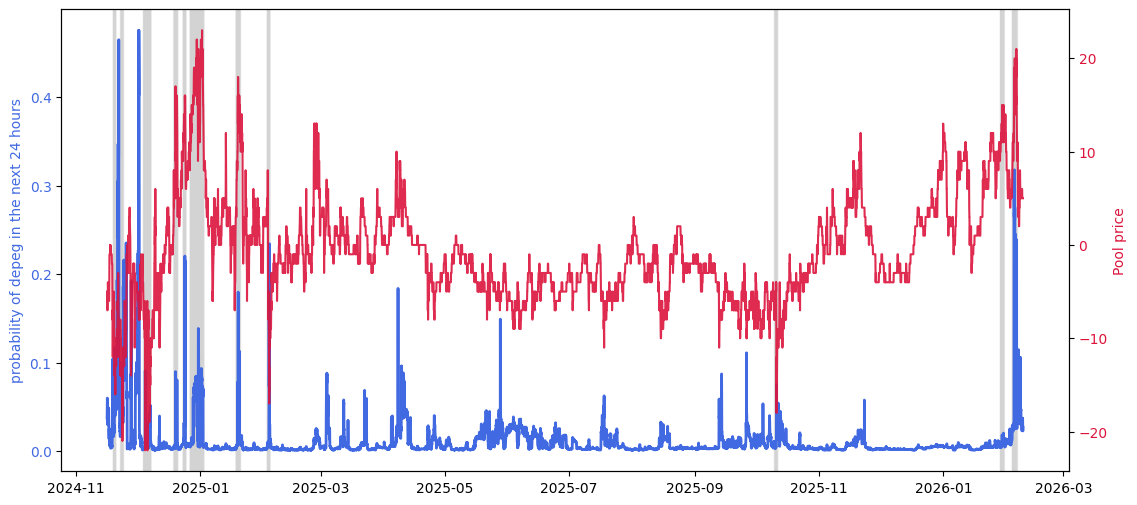

In [90]:
test_dates = df['timestamp'].iloc[val_end:]
fig, ax = plt.subplots(figsize=(13,6))
axi = ax.twinx()

# Fill vertically in red wherever y_test = 1
y_test_reset = y_test.reset_index(drop=True)
for i in range(len(y_test_reset)):
    if y_test_reset.iloc[i] == 1:
        ax.axvspan(test_dates.iloc[i], test_dates.iloc[min(i+1, len(test_dates)-1)], 
                   color='lightgrey', alpha=0.2, zorder=0)

ax.plot(test_dates, proba_test, label="Predicted Probability", color="royalblue", lw =2, zorder=2)
axi.plot(test_dates, X_test['poolTick'].reset_index(drop=True), label="Pool price", color = 'crimson', lw=1.5, alpha = 0.9, zorder =1)
# axi.plot(test_dates,y_test, label="Pool price", color = 'crimson', lw=1.5)
ax.set_ylabel("probability of depeg in the next 24 hours", color='royalblue')
axi.set_ylabel("Pool price", color='crimson')
ax.tick_params(axis='y', labelcolor='royalblue')
axi.tick_params(axis='y', labelcolor='crimson')
plt.savefig('./figs/predictions_over_time.png', dpi=300, transparent = True, bbox_inches='tight')

In [92]:
usdt = pd.read_parquet('./data/AAVE/aave_v3_usdt_eth.parquet')['lender_variable_apr']
usdc = pd.read_parquet('./data/AAVE/aave_v3_usdc_eth.parquet')['lender_variable_apr']

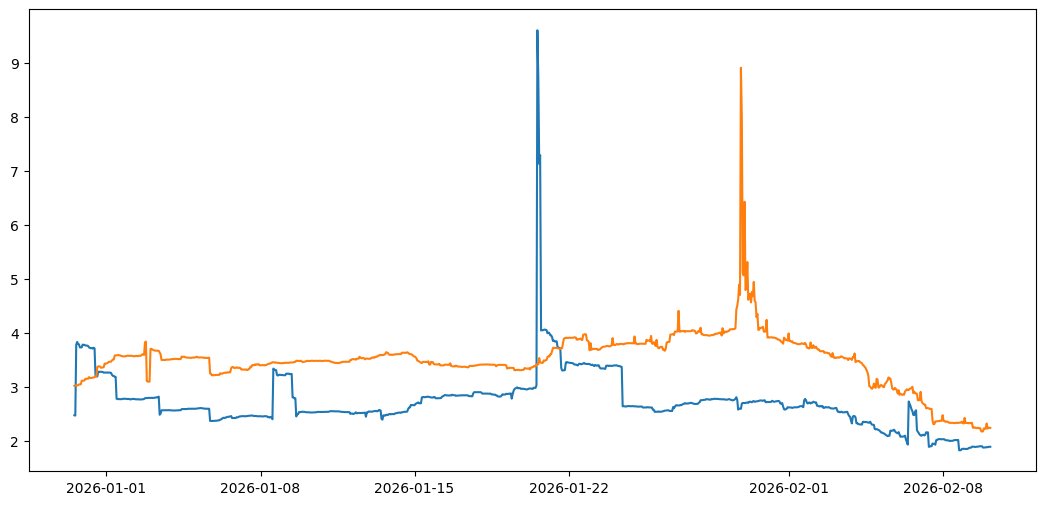

In [96]:
fig, ax = plt.subplots(figsize=(13,6))
plt.plot(usdt.iloc[-1000:])
plt.plot(usdc.iloc[-1000:])

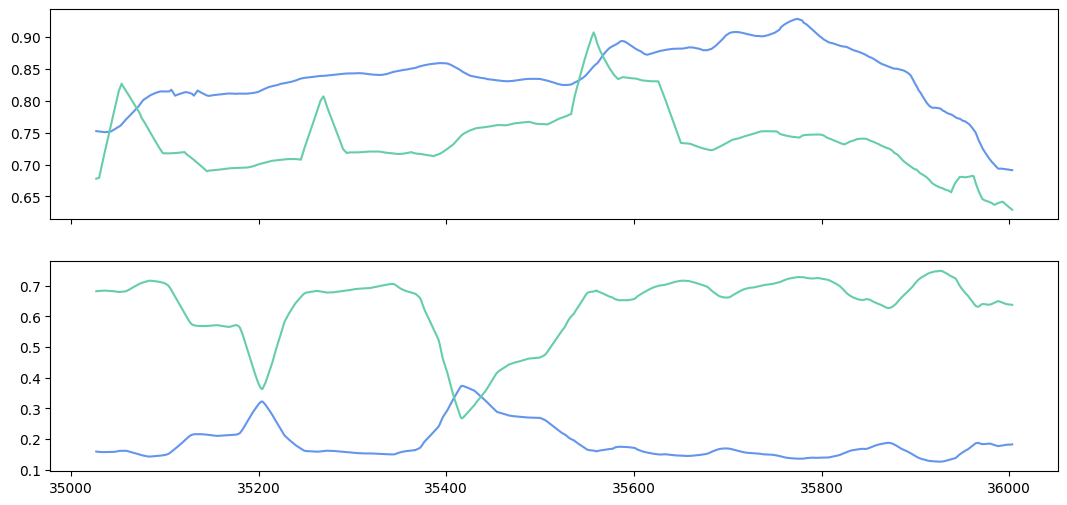

In [106]:
dt = df.iloc[-1000:]
fig, ax = plt.subplots(2,1, sharex = True, figsize=(13,6))
ax[0].plot(dt['utilisation_rate_usdc'].rolling(24).mean(), color = 'cornflowerblue', lw = 1.5)
ax[0].plot(dt['utilisation_rate_usdt'].rolling(24).mean(), color = 'mediumaquamarine',lw = 1.5)
ax[1].plot(dt['w_USDC'].rolling(24).mean(), color = 'cornflowerblue', lw=1.5)
ax[1].plot(dt['w_USDT'].rolling(24).mean(), color = 'mediumaquamarine', lw=1.5)

In [104]:
df['w_USDT']

0        0.285364
1        0.285399
2        0.285743
3        0.285576
4        0.285849
           ...   
35999    0.636212
36000    0.636090
36001    0.636060
36002    0.636076
36003    0.623804
Name: w_USDT, Length: 36004, dtype: float32